<a href="https://colab.research.google.com/github/AndyMuloki/algo-trading/blob/main/%F0%9F%92%B9algo_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[▶️Source](https://youtu.be/9Y3yaoi9rUQ)

### Required Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mat
import sklearn as sk
import datetime as dt

In [ ]:
!pip install pandas-ta
import pandas_ta

In [ ]:
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web

In [ ]:
# !pip install statsmodels
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS as rs

### 1. Load SP500 stocks prices data

In [ ]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

In [ ]:
end_date = '2024-03-01'
start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)
df = yf.download(tickers = symbols_list,
                 start = start_date,
                 end = end_date).stack()

[*********************100%%**********************]  502 of 502 completed


In [ ]:
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

In [ ]:
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-03-03 A        36.738003   39.200001   39.230000   38.740002   38.919998   
           AAL      40.131641   41.880001   42.240002   41.230000   41.520000   
           AAPL     23.196978   25.375000   25.427500   25.112499   25.145000   
           ABBV     39.626129   55.930000   56.090000   55.150002   55.689999   
           ABT      33.467419   38.820000   38.889999   38.090000   38.560001   
...                       ...         ...         ...         ...         ...   
2024-02-29 XYL     127.050003  127.050003  127.480003  125.250000  125.910004   
           YUM     138.419998  138.419998  139.649994  137.949997  138.809998   
           ZBH     124.360001  124.360001  124.839996  122.900002  124.220001   
           ZBRA    279.480011  279.480011  282.000000  275.760010  276.049988   
           ZTS     198.330002  198.330002  200.529999  198.190002  200.500000   

Price                   volume  
date       ticker               
2016-03-03 A          946800.0  
           AAL       8812800.0  
           AAPL    147822800.0  
           ABBV      9283900.0  
           ABT      13516200.0  
...                        ...  
2024-02-29 XYL       1829200.0  
           YUM       2257700.0  
           ZBH       2415800.0  
           ZBRA       400900.0  
           ZTS       2849200.0  

[993316 rows x 6 columns]

### 2. Calculate features and technical indicators for each stock

* Garman-Klass Volatility
* RSI
* Bollinger Bands
* MACD
* ATR
* Dollar Volume

In [ ]:
# Garman-Klass Volatility
df['gkv'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - (2*np.log(2)-1) * ((np.log(df['adj close'])-np.log(df['open'])) ** 2)

In [ ]:
# RSI

# level 1 = ticker
# level 0 = date
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

<Axes: xlabel='date'>

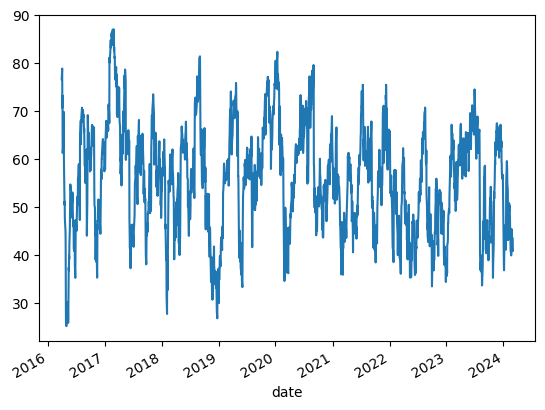

In [ ]:
df.xs('AAPL', level=1)['rsi'].plot()

In [ ]:
# Bollinger Bands
# pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
# df

In [ ]:
# ATR

def compute_atr(stock_data):
  atr = pandas_ta.atr(high=stock_data['high'],
                      low=stock_data['low'],
                      close=stock_data['close'],
                      length=14)
  return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

# df

In [ ]:
# MACD

def compute_macd(close):
  macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
  return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

# df

In [ ]:
# Dollar Volume

df['dollar_volume'] = (df['adj close'] * df['volume']) / 1e6

# df

### Aggregate to monthly level and filter top 150 most liquid stocks for each month

**3.1 To reduce training time and experiment with features and strats, convert the business-daily data to month-end freq.**

In [ ]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

last_cols

['adj close', 'gkv', 'rsi', 'bb_low', 'bb_mid', 'bb_high', 'atr', 'macd']

In [ ]:
data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                    df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-04-30 A           63.234640   38.460983 -1.278961  3.629313  3.629313   
           AAL        362.444599   33.241795  0.595127  3.549626  3.549626   
           AAPL      3970.854315   21.423492 -1.033812  3.135048  3.135048   
           ABBV       285.881329   43.633476 -0.965265  3.740925  3.740925   
           ABT        309.851825   33.741268 -0.896072  3.579932  3.579932   
...                          ...         ...       ...       ...       ...   
2024-02-29 XYL        180.158837  127.050003  0.180198  4.754219  4.754219   
           YUM        293.995977  138.419998  0.229732  4.835538  4.835538   
           ZBH        222.636824  124.360001 -0.227114  4.808937  4.808937   
           ZBRA       118.319971  279.480011  0.355421  5.456878  5.456878   
           ZTS        457.126920  198.330002  0.914995  5.214124  5.214124   

                     bb_mid       gkv      macd        rsi  
date       ticker                                           
2016-04-30 A       3.629313 -0.001300  0.095242  55.140847  
           AAL     3.549626 -0.000915 -1.541273  25.755570  
           AAPL    3.135048 -0.003020 -0.522189  25.339858  
           ABBV    3.740925 -0.043365  0.255673  64.463352  
           ABT     3.579932 -0.011388 -0.013602  32.794329  
...                     ...       ...       ...        ...  
2024-02-29 XYL     4.754219  0.000124  1.829336  71.011659  
           YUM     4.835538  0.000072  1.586266  66.401726  
           ZBH     4.808937  0.000122  0.316534  51.330560  
           ZBRA    5.456878  0.000191  0.840471  59.303912  
           ZTS     5.214124  0.000023  0.559725  56.950659  

[46898 rows x 9 columns]

**3.2 Calculate 5-year rolling average of dollar volume for each stock before filtering**

In [ ]:
print(data.columns)

# make sure 'dollar_volume' is among the columns

Index(['dollar_volume', 'adj close', 'atr', 'bb_high', 'bb_low', 'bb_mid',
       'gkv', 'macd', 'rsi'],
      dtype='object')


In [ ]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2016-04-30 A                 NaN   38.460983 -1.278961  3.629313  3.629313   
           AAL               NaN   33.241795  0.595127  3.549626  3.549626   
           AAPL              NaN   21.423492 -1.033812  3.135048  3.135048   
           ABBV              NaN   43.633476 -0.965265  3.740925  3.740925   
           ABT               NaN   33.741268 -0.896072  3.579932  3.579932   
...                          ...         ...       ...       ...       ...   
2024-02-29 XYL        106.684665  127.050003  0.180198  4.754219  4.754219   
           YUM        188.526572  138.419998  0.229732  4.835538  4.835538   
           ZBH        175.687743  124.360001 -0.227114  4.808937  4.808937   
           ZBRA       125.725195  279.480011  0.355421  5.456878  5.456878   
           ZTS        309.666395  198.330002  0.914995  5.214124  5.214124   

                     bb_mid       gkv      macd        rsi  
date       ticker                                           
2016-04-30 A       3.629313 -0.001300  0.095242  55.140847  
           AAL     3.549626 -0.000915 -1.541273  25.755570  
           AAPL    3.135048 -0.003020 -0.522189  25.339858  
           ABBV    3.740925 -0.043365  0.255673  64.463352  
           ABT     3.579932 -0.011388 -0.013602  32.794329  
...                     ...       ...       ...        ...  
2024-02-29 XYL     4.754219  0.000124  1.829336  71.011659  
           YUM     4.835538  0.000072  1.586266  66.401726  
           ZBH     4.808937  0.000122  0.316534  51.330560  
           ZBRA    5.456878  0.000191  0.840471  59.303912  
           ZTS     5.214124  0.000023  0.559725  56.950659  

[46898 rows x 9 columns]

In [ ]:
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

In [ ]:
data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

In [ ]:
# data

### 4. Calculate Monthly Returns for Different Time horizons as Features

* To capture time series dynamics that reflect, momentum patterns, we compute historical returns using the method .pct_change(lag), i.e. returns over various monthly periods as identified by lags

In [ ]:
def calculate_returns(df):
  outlier_cutoff = 0.005

  lags = [1,2,3,6,9,12]

  for lag in lags:
    df[f'return_{lag}m'] = (df['adj close']
                          .pct_change(lag)
                          .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                  upper=x.quantile(1-outlier_cutoff)))
                          .add(1)
                          .pow(1/lag)
                          .sub(1))
  return df

data =  data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

In [ ]:
# data

### 5. Download Fama-French Factors and Calculate Rolling Factor Betas

* Introduce Farma-French data to estimate the exposure of assets to common risk factors using linear regression
* Estimate historical exposures using the RollingOLS model

In [ ]:
# JetBrains Mono is the best font ever!

factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                                'famafrench',
                                start='2010')[0].drop('RF', axis=1)


In [ ]:
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

In [ ]:
factor_data.index.name = 'date'

In [ ]:
factor_data = factor_data.join(data['return_1m']).sort_index()

In [ ]:
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-03-31 AAL    -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.042212
           AAPL   -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.058051
           ABBV   -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.176797
           ABT    -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.006796
           ACN    -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.046643
...                   ...     ...     ...     ...     ...        ...
2024-01-31 VRTX    0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.065104
           VZ      0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.128136
           WFC     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.019504
           WMT     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.048208
           XOM     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.028306

[10218 rows x 6 columns]

**Filter out stocks with less than 10 months of data**

In [ ]:
obv = factor_data.groupby(level=1).size()

valid_stocks = obv[obv >= 10]

# valid_stocks

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2018-03-31 AAL    -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.042212
           AAPL   -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.058051
           ABBV   -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.176797
           ABT    -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.006796
           ACN    -0.0235  0.0359 -0.0021 -0.0046  0.0001  -0.046643
...                   ...     ...     ...     ...     ...        ...
2024-01-31 VRTX    0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.065104
           VZ      0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.128136
           WFC     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.019504
           WMT     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.048208
           XOM     0.0070 -0.0573 -0.0239  0.0068 -0.0095   0.028306

[10175 rows x 6 columns]

**Calculate Rolling Factor Betas**

In [ ]:
valid_stocks

In [ ]:
betas = (factor_data.groupby(level=1,
                                group_keys=False)
            .apply(lambda x: rs(endog=x['return_1m'],
                                        exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                        window=min(24, x.shape[0]),
                                        min_nobs=len(x.columns)+1)
            .fit(params_only=True)
            .params
            .drop('const', axis=1)))

In [ ]:
data = (data.join(betas.groupby('ticker').shift()))

In [ ]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

In [ ]:
data = data.drop('adj close', axis=1)

data = data.dropna()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10222 entries, (Timestamp('2018-03-31 00:00:00', freq='M'), 'AAL') to (Timestamp('2024-02-29 00:00:00', freq='M'), 'XOM')
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   atr         10222 non-null  float64
 1   bb_high     10222 non-null  float64
 2   bb_low      10222 non-null  float64
 3   bb_mid      10222 non-null  float64
 4   gkv         10222 non-null  float64
 5   macd        10222 non-null  float64
 6   rsi         10222 non-null  float64
 7   return_1m   10222 non-null  float64
 8   return_2m   10222 non-null  float64
 9   return_3m   10222 non-null  float64
 10  return_6m   10222 non-null  float64
 11  return_9m   10222 non-null  float64
 12  return_12m  10222 non-null  float64
 13  Mkt-RF      10222 non-null  float64
 14  SMB         10222 non-null  float64
 15  HML         10222 non-null  float64
 16  RMW         10222 non-null  float64
 17  CMA        

### 6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

**K-Means Clustering**


* Initialize predefined centroids for each cluster based on the research
* We will use the k-means++ initialization
* Then pre-define centroids for each cluster